# Import

In [1]:
import torch
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from fvcore.nn import FlopCountAnalysis, flop_count_table
import numpy as np
import matplotlib.pyplot as plt
import os
####################################################
from src.Mydataloader import LoadDataset
from src.Mymodel import Block
from src.Mymodel import MyResNet34
from src.Mymodel import MyResNet_CIFAR
from src.Mytraining import DoTraining

# Setup

In [2]:
"""Dataset selection"""
DATASET = "CIFAR10"
# DATASET = "CIFAR100"
# DATASET = "ImageNet2012"

"""Model selection for CIFAR"""
NUM_LAYERS_LEVEL = 5

"""Dataset parameters"""
BATCH = 256
SHUFFLE = True
NUMOFWORKERS = 8
PIN_MEMORY = True
SPLIT_RATIO = 0.95
"""optimizer parameters"""
OPTIMIZER = "SGD"
# OPTIMIZER = "Adam"
# OPTIMIZER = "Adam_decay"

"""Learning rate scheduler parameters"""
LOAD_BEFORE_TRAINING = False
LOAD_BEFORE_TRAINING = True
NUM_EPOCHS = 5000

"""Early stopping parameters"""
EARLYSTOPPINGPATIENCE = 1200
file_path = ""
if DATASET == "ImageNet2012":
    file_path = f"{DATASET}/MyResNet34_{BATCH}_{OPTIMIZER}"
else:
    file_path = f"{DATASET}/MyResNet{NUM_LAYERS_LEVEL*6+2}_{BATCH}_{OPTIMIZER}"
    
if SPLIT_RATIO != 0:
    file_path += f"_{int(SPLIT_RATIO*100)}"

In [3]:
file_path

'CIFAR10/MyResNet32_256_SGD_95'

# Loading the dataset

## Define Dateloader

In [4]:
from src.Mydataloader import LoadDataset

In [5]:
tmp = LoadDataset(root="data", seceted_dataset=DATASET, split_ratio=SPLIT_RATIO)
train_data, valid_data, test_data, COUNT_OF_CLASSES = tmp.Unpack()

/home/lee/anaconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


-----------------------------------------------------------------------
Dataset :  CIFAR10
- Length of Train Set :  47500
- Length of Valid Set :  2500
- Length of Test Set :  10000
- Count of Classes :  10
-----------------------------------------------------------------------


In [6]:
train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH,
    shuffle=SHUFFLE,
    num_workers=NUMOFWORKERS,
    pin_memory=PIN_MEMORY,
    # pin_memory_device="cuda",
    persistent_workers=True,
)
print("train.transforms =", train_data.transform, train_dataloader.batch_size)

if SPLIT_RATIO != 0:
    valid_dataloader = DataLoader(
        valid_data,
        batch_size=BATCH,
        shuffle=SHUFFLE,
        num_workers=NUMOFWORKERS,
        pin_memory=PIN_MEMORY,
        # pin_memory_device="cuda",
        persistent_workers=True,
    )
    print("valid.transforms =", valid_data.transform, valid_dataloader.batch_size)
elif SPLIT_RATIO == 0:
    valid_dataloader = None
    
test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH,
    shuffle=SHUFFLE,
    num_workers=NUMOFWORKERS,
    pin_memory=PIN_MEMORY,
    # pin_memory_device="cuda",
    persistent_workers=True,
)
print("test.transforms =", test_data.transform, test_dataloader.batch_size)

train.transforms = Compose(
      ToTensor()
      Submean()
      AutoAugment(interpolation=InterpolationMode.NEAREST, policy=AutoAugmentPolicy.CIFAR10)
      RandomHorizontalFlip(p=0.5)
) 256
valid.transforms = Compose(
      ToTensor()
      Submean()
) 256
test.transforms = Compose(
      ToTensor()
      Submean()
) 256


## Confirm that the dataset is loaded properly

In [7]:
if DATASET != "ImageNet2012":
    for X, y in test_dataloader:
        print(f"Shape of X [N, C, H, W]: {X.shape}")
        print("mean of X", X.mean(dim=(0, 2, 3)))
        print(f"Shape of y: {y.shape} {y.dtype}")
        break

Shape of X [N, C, H, W]: torch.Size([256, 3, 32, 32])
mean of X tensor([-4.5884e-09, -2.7975e-09, -4.6145e-10])
Shape of y: torch.Size([256]) torch.int64


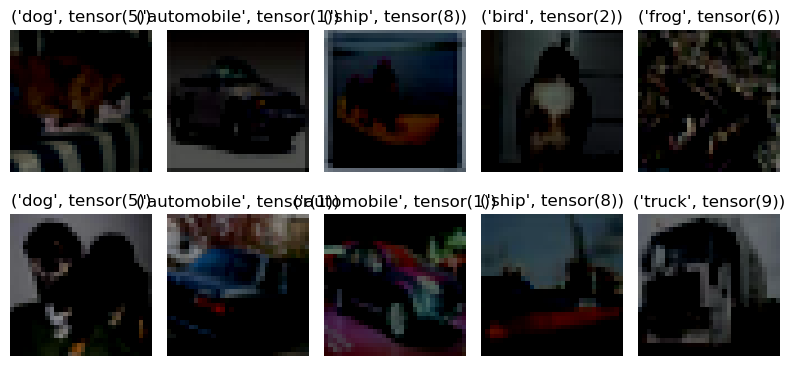

In [8]:
if DATASET != "ImageNet2012":
    class_names = test_dataloader.dataset.classes
    count = 0
    fig, axs = plt.subplots(2, 5, figsize=(8, 4))

    for images, labels in test_dataloader:
        images = images.numpy()

        for i in range(len(images)):
            image = images[i]
            label = labels[i]
            image = np.transpose(image, (1, 2, 0))
            image = np.clip(image, 0, 1)
            ax = axs[count // 5, count % 5]
            ax.imshow(image)
            ax.set_title(f"{class_names[label], label}")
            ax.axis('off')
            count += 1
            
            if count == 10:
                break
        if count == 10:
            break
    plt.tight_layout()
    plt.show()

# Define ResNet

In [9]:
from src.Mymodel import MyResNet34
from src.Mymodel import MyResNet_CIFAR

## Model Confirm

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
if DATASET == "CIFAR10" or DATASET == "CIFAR100":
    """ResNet{20, 32, 44, 56, 110, 1202} for CIFAR"""
    model = MyResNet_CIFAR(
        num_classes=COUNT_OF_CLASSES, num_layer_factor=NUM_LAYERS_LEVEL
    ).to(device)
    print(f"ResNet-{5*6+2} for {DATASET} is loaded.")

elif DATASET == "ImageNet2012":
    """ResNet34 for ImageNet 2012"""
    model = MyResNet34(num_classes=COUNT_OF_CLASSES).to(device)
    # model = models.resnet34(pretrained=True).to(device)
    # model = models.resnet34(pretrained=False).to(device)
    print(f"ResNet-34 for {DATASET} is loaded.")

# model.named_modules

ResNet-32 for CIFAR10 is loaded.


In [12]:
tmp_input = torch.rand(BATCH, 3, 32, 32).to(device)
flops = FlopCountAnalysis(model, tmp_input)
print(flop_count_table(flops))

| module                   | #parameters or shape   | #flops     |
|:-------------------------|:-----------------------|:-----------|
| model                    | 0.464M                 | 17.997G    |
|  conv32blocks            |  23.792K               |  6.363G    |
|   conv32blocks.0         |   0.432K               |   0.113G   |
|    conv32blocks.0.weight |    (16, 3, 3, 3)       |            |
|   conv32blocks.1         |   4.672K               |   1.25G    |
|    conv32blocks.1.conv1  |    2.304K              |    0.604G  |
|    conv32blocks.1.bn1    |    32                  |    20.972M |
|    conv32blocks.1.conv2  |    2.304K              |    0.604G  |
|    conv32blocks.1.bn2    |    32                  |    20.972M |
|   conv32blocks.2         |   4.672K               |   1.25G    |
|    conv32blocks.2.conv1  |    2.304K              |    0.604G  |
|    conv32blocks.2.bn1    |    32                  |    20.972M |
|    conv32blocks.2.conv2  |    2.304K              |    0.604

# Define Training

## Define Optimazer
#### ResNet32 for CIFAR10
- SGD
- Batch size = 128 * 2 GPU
- lr : 0.1 -> 0.01 -> 0.001 (at 32k, 48k and terminate on 64k iter)
  - divided by 10 when the error plateaus
- Weight Decay = 0.0001
- Momentum = 0.9
#### ResNet34 for ImageNet2012
- SGD
- Batch size = 256
- lr = 0.1
  - divided by 10 when the error plateaus
  - amount 60k iter
- Weight Decay = 0.0001
- Momentum = 0.9

In [13]:
criterion = nn.CrossEntropyLoss()

if OPTIMIZER == "Adam":
    optimizer = torch.optim.Adam(model.parameters())
    # optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=1e-4)
elif OPTIMIZER == "Adam_decay":
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "SGD":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001
    )

## Define Early Stopping

In [14]:
# Early stopping 관련 변수 초기화
best_val_loss = float("inf")
early_stop_counter = 0

## Define Learning Rate schedualer

In [15]:
scheduler_mapping = {"CIFAR100": 100, "CIFAR10": 1000, "ImageNet2012": 30}
MIN_LR = 0.0001
scheduler = ReduceLROnPlateau(
    optimizer,
    mode="min",
    patience=scheduler_mapping[DATASET],
    factor=0.1,
    verbose=True,
    threshold=1e-4,
    min_lr=MIN_LR,
)

In [16]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

## Load before process

In [17]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

if LOAD_BEFORE_TRAINING == True and os.path.exists("logs/" + file_path + ".pth.tar"):
    # Read checkpoint as desired, e.g.,
    checkpoint = torch.load(
        "logs/" + file_path + ".pth.tar",
        map_location=lambda storage, loc: storage.cuda(device),
    )
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    scaler.load_state_dict(checkpoint["scaler"])
    logs = checkpoint["logs"]

    print("Suceessfully loaded the All setting and Log file.")
    print(file_path)
    print(f"Current epoch is {len(logs['train_loss'])}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
else:
    # Create a dictionary to store the variables
    train_loss = []
    train_acc = []
    eval_loss = []
    valid_acc = []
    test_loss = []
    test_acc = []

    logs = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "valid_loss": eval_loss,
        "valid_acc": valid_acc,
        "test_loss": test_loss,
        "test_acc": test_acc,
    }
    print("File does not exist. Created a new log.")

Suceessfully loaded the All setting and Log file.
CIFAR10/MyResNet32_256_SGD_95
Current epoch is 2286
Current learning rate: 0.1


In [18]:
# CHECK = 1999
# logs["train_loss"] = logs["train_loss"][:CHECK]
# logs["train_acc"] = logs["train_acc"][:CHECK]
# logs["valid_loss"] = logs["valid_loss"][:CHECK]
# logs["valid_acc"] = logs["valid_acc"][:CHECK]
# logs["test_loss"] = logs["test_loss"][:CHECK]
# logs["test_acc"] = logs["test_acc"][:CHECK]
# model.load_state_dict(torch.load(f"models/{file_path}.pth"))

# [Training Loop]

In [19]:
from src.Mytraining import DoTraining

In [20]:
Training = DoTraining(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    scheduler=scheduler,
    device=device,
    logs=logs,
    file_path=file_path,
)
pre_epochs = len(Training.logs["train_loss"])

for epoch in range(NUM_EPOCHS):
    print(f"[Epoch {epoch+1+pre_epochs}/{NUM_EPOCHS}] :")

    if DATASET == "ImageNet2012":
        eval_loss = Training.SingleEpoch(train_dataloader, valid_dataloader)
    else:
        eval_loss = Training.SingleEpoch(
            train_dataloader, valid_dataloader, test_dataloader
        )

    # Early stopping check
    if eval_loss < best_val_loss:
        best_val_loss = eval_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "models/" + file_path + ".pth")

    else:
        early_stop_counter += 1
        if early_stop_counter >= EARLYSTOPPINGPATIENCE:
            print(f"Early stopping after {epoch} epochs without improvement.")
            break

    print("-" * 50)

[Epoch 2287/5000] :


100%|██████████| 186/186 [00:09<00:00, 20.55it/s]

Train Loss: 0.0005 | Train Acc: 95.71%


Valid Loss: 0.1700 | Valid Acc: 94.04%
Test  Loss: 0.7938 | Test Acc: 81.36%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2288/5000] :


100%|██████████| 186/186 [00:08<00:00, 21.90it/s]


Train Loss: 0.0002 | Train Acc: 100.00%
Valid Loss: 0.2041 | Valid Acc: 93.80%
Test  Loss: 0.8590 | Test Acc: 81.88%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2289/5000] :


100%|██████████| 186/186 [00:08<00:00, 21.20it/s]


Train Loss: 0.0002 | Train Acc: 99.29%
Valid Loss: 0.1249 | Valid Acc: 95.84%
Test  Loss: 0.7496 | Test Acc: 82.55%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2290/5000] :


100%|██████████| 186/186 [00:08<00:00, 22.98it/s]


Train Loss: 0.0002 | Train Acc: 97.86%
Valid Loss: 0.1394 | Valid Acc: 95.00%
Test  Loss: 0.8314 | Test Acc: 81.77%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2291/5000] :


100%|██████████| 186/186 [00:08<00:00, 21.50it/s]


Train Loss: 0.0002 | Train Acc: 99.29%
Valid Loss: 0.1245 | Valid Acc: 96.00%
Test  Loss: 0.8326 | Test Acc: 82.72%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2292/5000] :


100%|██████████| 186/186 [00:08<00:00, 21.53it/s]


Train Loss: 0.0005 | Train Acc: 97.14%
Valid Loss: 0.2188 | Valid Acc: 92.68%
Test  Loss: 0.9094 | Test Acc: 80.93%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2293/5000] :


100%|██████████| 186/186 [00:08<00:00, 21.00it/s]


Train Loss: 0.0001 | Train Acc: 99.29%
Valid Loss: 0.1958 | Valid Acc: 94.16%
Test  Loss: 0.8736 | Test Acc: 81.49%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2294/5000] :


100%|██████████| 186/186 [00:09<00:00, 19.53it/s]


Train Loss: 0.0002 | Train Acc: 98.57%
Valid Loss: 0.2732 | Valid Acc: 91.36%
Test  Loss: 0.9192 | Test Acc: 80.58%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2295/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.00it/s]


Train Loss: 0.0001 | Train Acc: 99.29%
Valid Loss: 0.2735 | Valid Acc: 91.88%
Test  Loss: 0.9589 | Test Acc: 81.42%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2296/5000] :


100%|██████████| 186/186 [00:11<00:00, 16.52it/s]


Train Loss: 0.0002 | Train Acc: 98.57%
Valid Loss: 0.3125 | Valid Acc: 91.48%
Test  Loss: 1.0213 | Test Acc: 80.80%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2297/5000] :


100%|██████████| 186/186 [00:08<00:00, 21.93it/s]


Train Loss: 0.0004 | Train Acc: 97.86%
Valid Loss: 0.3025 | Valid Acc: 90.12%
Test  Loss: 0.9584 | Test Acc: 80.46%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2298/5000] :


100%|██████████| 186/186 [00:08<00:00, 21.20it/s]


Train Loss: 0.0003 | Train Acc: 97.86%
Valid Loss: 0.2637 | Valid Acc: 92.20%
Test  Loss: 0.9723 | Test Acc: 80.99%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2299/5000] :


100%|██████████| 186/186 [00:11<00:00, 16.02it/s]


Train Loss: 0.0004 | Train Acc: 97.14%
Valid Loss: 0.1752 | Valid Acc: 94.04%
Test  Loss: 0.7754 | Test Acc: 82.88%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2300/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.74it/s]


Train Loss: 0.0002 | Train Acc: 97.86%
Valid Loss: 0.2671 | Valid Acc: 92.08%
Test  Loss: 0.8678 | Test Acc: 82.03%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2301/5000] :


100%|██████████| 186/186 [00:13<00:00, 13.72it/s]


Train Loss: 0.0003 | Train Acc: 97.86%
Valid Loss: 0.2261 | Valid Acc: 92.52%
Test  Loss: 0.9083 | Test Acc: 82.39%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2302/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.62it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.2378 | Valid Acc: 92.56%
Test  Loss: 0.8281 | Test Acc: 82.74%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2303/5000] :


100%|██████████| 186/186 [00:09<00:00, 19.86it/s]


Train Loss: 0.0001 | Train Acc: 100.00%
Valid Loss: 0.2654 | Valid Acc: 91.76%
Test  Loss: 0.9339 | Test Acc: 80.79%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2304/5000] :


100%|██████████| 186/186 [00:08<00:00, 22.44it/s]


Train Loss: 0.0002 | Train Acc: 99.29%
Valid Loss: 0.2009 | Valid Acc: 94.00%
Test  Loss: 0.8365 | Test Acc: 83.12%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2305/5000] :


100%|██████████| 186/186 [00:08<00:00, 21.63it/s]


Train Loss: 0.0008 | Train Acc: 95.71%
Valid Loss: 0.2462 | Valid Acc: 91.92%
Test  Loss: 0.8518 | Test Acc: 81.91%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2306/5000] :


100%|██████████| 186/186 [00:08<00:00, 22.08it/s]


Train Loss: 0.0003 | Train Acc: 97.86%
Valid Loss: 0.2776 | Valid Acc: 92.40%
Test  Loss: 0.8669 | Test Acc: 82.21%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2307/5000] :


100%|██████████| 186/186 [00:08<00:00, 20.70it/s]


Train Loss: 0.0001 | Train Acc: 99.29%
Valid Loss: 0.2021 | Valid Acc: 93.52%
Test  Loss: 0.7580 | Test Acc: 83.20%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2308/5000] :


100%|██████████| 186/186 [00:08<00:00, 23.14it/s]


Train Loss: 0.0001 | Train Acc: 99.29%
Valid Loss: 0.2230 | Valid Acc: 93.28%
Test  Loss: 0.8265 | Test Acc: 83.14%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2309/5000] :


100%|██████████| 186/186 [00:08<00:00, 20.93it/s]


Train Loss: 0.0001 | Train Acc: 99.29%
Valid Loss: 0.3384 | Valid Acc: 90.64%
Test  Loss: 1.0062 | Test Acc: 79.73%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2310/5000] :


100%|██████████| 186/186 [00:09<00:00, 19.71it/s]


Train Loss: 0.0002 | Train Acc: 97.86%
Valid Loss: 0.2685 | Valid Acc: 91.96%
Test  Loss: 0.9038 | Test Acc: 82.47%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2311/5000] :


100%|██████████| 186/186 [00:08<00:00, 22.75it/s]


Train Loss: 0.0003 | Train Acc: 99.29%
Valid Loss: 0.3432 | Valid Acc: 90.48%
Test  Loss: 0.9652 | Test Acc: 81.16%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2312/5000] :


100%|██████████| 186/186 [00:08<00:00, 20.80it/s]


Train Loss: 0.0002 | Train Acc: 99.29%
Valid Loss: 0.5166 | Valid Acc: 87.28%
Test  Loss: 1.0956 | Test Acc: 78.77%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2313/5000] :


100%|██████████| 186/186 [00:08<00:00, 21.86it/s]


Train Loss: 0.0004 | Train Acc: 97.86%
Valid Loss: 0.2656 | Valid Acc: 92.96%
Test  Loss: 0.8497 | Test Acc: 83.25%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2314/5000] :


100%|██████████| 186/186 [00:08<00:00, 21.30it/s]


Train Loss: 0.0003 | Train Acc: 97.86%
Valid Loss: 0.4026 | Valid Acc: 89.12%
Test  Loss: 0.9912 | Test Acc: 80.56%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2315/5000] :


100%|██████████| 186/186 [00:08<00:00, 21.74it/s]


Train Loss: 0.0004 | Train Acc: 97.14%
Valid Loss: 0.4432 | Valid Acc: 88.36%
Test  Loss: 0.9926 | Test Acc: 80.31%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2316/5000] :


100%|██████████| 186/186 [00:08<00:00, 20.96it/s]


Train Loss: 0.0005 | Train Acc: 97.14%
Valid Loss: 0.2633 | Valid Acc: 91.80%
Test  Loss: 0.7663 | Test Acc: 83.63%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2317/5000] :


100%|██████████| 186/186 [00:08<00:00, 21.31it/s]


Train Loss: 0.0005 | Train Acc: 97.14%
Valid Loss: 0.2497 | Valid Acc: 91.68%
Test  Loss: 0.7889 | Test Acc: 83.07%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2318/5000] :


100%|██████████| 186/186 [00:08<00:00, 22.05it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3948 | Valid Acc: 89.12%
Test  Loss: 1.0005 | Test Acc: 80.55%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2319/5000] :


100%|██████████| 186/186 [00:08<00:00, 22.50it/s]


Train Loss: 0.0001 | Train Acc: 98.57%
Valid Loss: 0.3213 | Valid Acc: 91.12%
Test  Loss: 0.9083 | Test Acc: 81.79%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2320/5000] :


100%|██████████| 186/186 [00:08<00:00, 22.07it/s]


Train Loss: 0.0001 | Train Acc: 100.00%
Valid Loss: 0.2139 | Valid Acc: 93.44%
Test  Loss: 0.7728 | Test Acc: 83.86%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2321/5000] :


100%|██████████| 186/186 [00:08<00:00, 21.54it/s]


Train Loss: 0.0001 | Train Acc: 100.00%
Valid Loss: 0.3178 | Valid Acc: 91.08%
Test  Loss: 0.8518 | Test Acc: 82.60%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2322/5000] :


100%|██████████| 186/186 [00:09<00:00, 20.38it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.2813 | Valid Acc: 91.52%
Test  Loss: 0.8440 | Test Acc: 82.43%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2323/5000] :


100%|██████████| 186/186 [00:08<00:00, 21.01it/s]


Train Loss: 0.0001 | Train Acc: 99.29%
Valid Loss: 0.2649 | Valid Acc: 91.88%
Test  Loss: 0.8260 | Test Acc: 83.06%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2324/5000] :


100%|██████████| 186/186 [00:08<00:00, 21.85it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.2472 | Valid Acc: 92.96%
Test  Loss: 0.8089 | Test Acc: 83.25%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2325/5000] :


100%|██████████| 186/186 [00:09<00:00, 20.37it/s]


Train Loss: 0.0008 | Train Acc: 94.29%
Valid Loss: 0.4813 | Valid Acc: 87.72%
Test  Loss: 0.9975 | Test Acc: 79.82%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2326/5000] :


100%|██████████| 186/186 [00:08<00:00, 20.93it/s]


Train Loss: 0.0007 | Train Acc: 93.57%
Valid Loss: 0.5585 | Valid Acc: 85.92%
Test  Loss: 0.9584 | Test Acc: 79.27%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2327/5000] :


 25%|██▌       | 47/186 [00:02<00:06, 21.78it/s]

## Training Results

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

# 첫 번째 그래프: Training and Test Loss
axs[0].plot(logs["train_loss"], label="Training Loss")
axs[0].plot(logs["valid_loss"], label="Validation Loss")
axs[0].plot(logs["test_loss"], label="Test Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training, Validation and Test Loss")
axs[0].legend()

# 두 번째 그래프: Training and Test Accuracy
axs[1].plot(logs["train_acc"], label="Training Accuracy")
axs[1].plot(logs["valid_acc"], label="Validation Accuracy")
axs[1].plot(logs["test_acc"], label="Test Accuracy")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].set_title("Training, Validation and Test Accuracy")
axs[1].legend()

# 그래프를 보여줍니다.
plt.tight_layout()
plt.show()

In [ ]:
print(len(logs["train_loss"]))
print(len(logs["train_acc"]))
print(len(logs["valid_loss"]))
print(len(logs["valid_acc"]))
print(len(logs["test_loss"]))
print(len(logs["test_acc"]))

- 주피터노트북 output set
- @tag:notebookOutputLayout

In [ ]:
for i in range(len(logs["train_loss"])):
    print(
        f"{i+1} epoch: train_loss={logs['train_loss'][i]:.4f}, train_acc={logs['train_acc'][i]:.4f}, test_loss={logs['test_loss'][i]:.4f}, test_acc={logs['test_acc'][i]:.4f}"
    )